## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.6.0+cu124
cuda


In [2]:
!nvidia-smi

Thu May 15 13:16:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             13W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import gdown
import zipfile
import os

file_url = 'https://drive.google.com/uc?id=1iNJpbR5LSsOUBZ-MYeavqJyRBMjSC8yg'
file_name = 'eye_dataset.zip'

# Download the file from Google Drive
gdown.download(file_url, file_name, quiet=False)
extract_dir = './dataset'

# Extract the zip file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Remove the zip file after extraction
os.remove(file_name)
print("Files extracted successfully to:", extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1iNJpbR5LSsOUBZ-MYeavqJyRBMjSC8yg
From (redirected): https://drive.google.com/uc?id=1iNJpbR5LSsOUBZ-MYeavqJyRBMjSC8yg&confirm=t&uuid=504bdda0-6383-454c-9973-f8e3355f8f6f
To: /content/eye_dataset.zip
100%|██████████| 217M/217M [00:06<00:00, 36.0MB/s]


Files extracted successfully to: ./dataset


In [4]:
from pathlib import Path
import os

# Setup path to data folder
image_path = Path("/content/dataset/Eye_Diseases")

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in '/content/dataset/Eye_Diseases'.
There are 6 directories and 0 images in '/content/dataset/Eye_Diseases/test'.
There are 0 directories and 200 images in '/content/dataset/Eye_Diseases/test/glucoma'.
There are 0 directories and 200 images in '/content/dataset/Eye_Diseases/test/cataract'.
There are 0 directories and 200 images in '/content/dataset/Eye_Diseases/test/normal'.
There are 0 directories and 200 images in '/content/dataset/Eye_Diseases/test/amd'.
There are 0 directories and 200 images in '/content/dataset/Eye_Diseases/test/myopia'.
There are 0 directories and 200 images in '/content/dataset/Eye_Diseases/test/noneye'.
There are 6 directories and 0 images in '/content/dataset/Eye_Diseases/train'.
There are 0 directories and 2016 images in '/content/dataset/Eye_Diseases/train/glucoma'.
There are 0 directories and 2052 images in '/content/dataset/Eye_Diseases/train/cataract'.
There are 0 directories and 2101 images in '/content/dataset/Eye_Di

## 2. Data Preparation (Visualization)

Random image path: /content/dataset/Eye_Diseases/train/amd/212_left.jpg
Image Class: amd
Image Height: 224
Image Width: 224


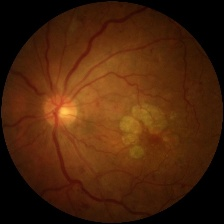

In [5]:
import random
from PIL import Image

# random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))
# print(len(image_path_list))
random_image_path = random.choice(image_path_list)
# print(random_image_path)
# the image class is the name of the directory where iamges resides
image_class = random_image_path.parent.stem
# print(image_class)

img = Image.open(random_image_path)

# Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image Class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

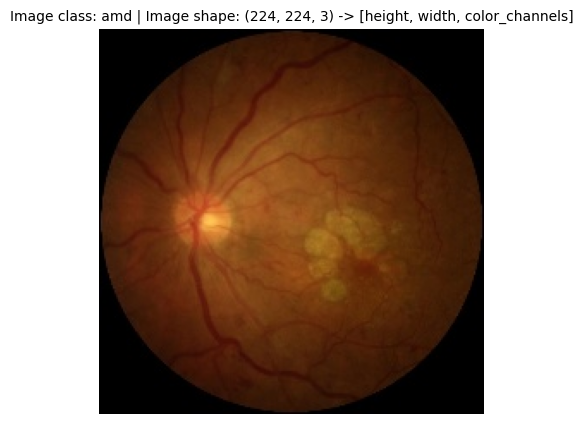

In [6]:
# Visualizing using matplotliib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
fig = plt.figure(figsize=(6, 5))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]", fontsize = 10)
plt.axis(False)
plt.show()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
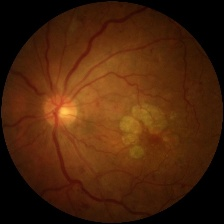

In [7]:
img_as_array

## 3. Transforming data

In [8]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

print(torchvision.__version__)

# Transform image
data_transform = transforms.Compose([
    # Resize our images to 224x224
    # transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])


transformed_data = data_transform(img)
transformed_data, transformed_data.shape, transformed_data.dtype

0.21.0+cu124


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 torch.Size([3, 224, 224]),
 torch.float32)

## 4. Loading data with `ImageFolder`

In [9]:
# Setup train and test paths
train_dir = 'dataset/Eye_Diseases/train'
test_dir = 'dataset/Eye_Diseases/test'

train_dir, test_dir

('dataset/Eye_Diseases/train', 'dataset/Eye_Diseases/test')

In [10]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # Transforms input data into tensors
                                  target_transform = None)  # Transform labels into none

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 12020
     Root location: dataset/Eye_Diseases/train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1200
     Root location: dataset/Eye_Diseases/test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

In [11]:
# Get class names as lists
class_names = train_data.classes
class_names

['amd', 'cataract', 'glucoma', 'myopia', 'noneye', 'normal']

In [12]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'amd': 0, 'cataract': 1, 'glucoma': 2, 'myopia': 3, 'noneye': 4, 'normal': 5}

In [13]:
train_data.samples[:12000:2000]

[('dataset/Eye_Diseases/train/amd/102_left.jpg', 0),
 ('dataset/Eye_Diseases/train/cataract/2139_right.jpg', 1),
 ('dataset/Eye_Diseases/train/glucoma/1269_right.jpg', 2),
 ('dataset/Eye_Diseases/train/myopia/1543_right.jpg', 3),
 ('dataset/Eye_Diseases/train/noneye/067.jpg', 4),
 ('dataset/Eye_Diseases/train/normal/2365_left.jpg', 5)]

In [14]:
# Index on the train_data Dataset to get a single iamge and label
img, label = train_data[0][0], train_data[0][1]

img, img.dtype, label, type(label), class_names[label]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 torch.float32,
 0,
 int,
 'amd')

In [15]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)
img.shape, img_permute.shape

(torch.Size([3, 224, 224]), torch.Size([224, 224, 3]))

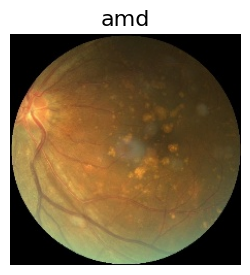

In [16]:
# Plot the image
plt.figure(figsize = (3, 3))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize = 16);

## 5. Turn loaded images into `Dataloaders`

In [17]:
# Train and test dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

len(train_dataloader), len(test_dataloader)

(376, 38)

In [18]:
img, label = next(iter(train_dataloader))

img.shape, label.shape     # {img.shape} -> [batch_size, color_channels, height, width]

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## 6. Build Model from scratch using `TinyVGG` as Base Model

In [19]:
class ImprovedTinyVGGModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super(ImprovedTinyVGGModel, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(hidden_units),
            nn.Dropout(0.2)  # Dropout for regularization
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(4 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(4 * hidden_units),
            # nn.Dropout(0.2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(4 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(4 * hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(2 * hidden_units),
            nn.Dropout(0.2)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(2 * hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, output_shape, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(output_shape),
            # nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1176, hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.classifier(x)
        return x

In [20]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [21]:
from torchinfo import summary

# Instance of Improved TinyVGG
model = ImprovedTinyVGGModel(3, 48, len(class_names)).to(device)   # (input_shape, hidden_units, output_shape)
summary(model, input_size = [1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedTinyVGGModel                     [1, 6]                    --
├─Sequential: 1-1                        [1, 48, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 48, 224, 224]         1,344
│    └─ReLU: 2-2                         [1, 48, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 48, 224, 224]         20,784
│    └─ReLU: 2-4                         [1, 48, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 48, 112, 112]         --
│    └─BatchNorm2d: 2-6                  [1, 48, 112, 112]         96
│    └─Dropout: 2-7                      [1, 48, 112, 112]         --
├─Sequential: 1-2                        [1, 192, 56, 56]          --
│    └─Conv2d: 2-8                       [1, 192, 112, 112]        83,136
│    └─ReLU: 2-9                         [1, 192, 112, 112]        --
│    └─Conv2d: 2-10                      [1, 192, 112, 112]        331,968

In [22]:
# Trying forward pass to check the model
model(img.to(device))

tensor([[-0.7084,  0.6655, -0.1445, -0.0158, -0.6918, -0.0633],
        [ 0.1308, -0.2571,  0.2573,  0.3101, -0.2064,  0.1014],
        [ 0.4471,  0.0175, -0.7859, -0.1978, -0.7337, -0.1997],
        [-0.2444, -0.0703, -0.1415, -0.3657, -0.0544,  0.0972],
        [-0.0468,  0.1216,  0.0651,  0.2193, -0.1470, -0.4926],
        [ 0.0239, -0.0109, -0.1861, -0.0874, -0.0260, -0.3041],
        [ 0.1205,  0.1718, -0.5038, -0.0407, -0.4117,  0.1656],
        [-0.0367, -0.0413,  0.0066,  0.0743, -0.1667,  0.1742],
        [-0.1044,  0.2509, -0.0720, -0.2086, -0.0681,  0.3704],
        [-0.3544,  0.0520,  0.0210, -0.2254, -0.1856, -0.4289],
        [-0.2635,  0.5045, -0.4695, -0.2804, -0.1948,  0.3262],
        [-0.7543, -0.1622, -0.4197,  0.4082, -0.8577, -0.0693],
        [ 0.0044,  0.4053,  0.0125,  0.0671, -0.1972,  0.1490],
        [ 0.1268,  0.0176, -0.0487, -0.1782, -0.0514,  0.0378],
        [-0.5231,  1.3347, -0.3731,  0.2456, -1.4045,  0.1099],
        [-0.8113,  0.2949, -0.0664,  0.1

## 7. Create Train/Test Loop Function

In [23]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc = 0, 0

    # Turn on inference
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [24]:
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):

  # Create a empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss":[],
             "test_acc": []}

  # Loop through training and testing steps for no of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       optimizer = optimizer,
                                       loss_fn = loss_fn)

    test_loss, test_acc = test_step(model = model,
                                     dataloader = test_dataloader,
                                     loss_fn = loss_fn)

    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} - Train acc: {(train_acc*100):.2f}% -  Test loss: {test_loss:.4f} - Test acc: {(test_acc*100):.2f}%')

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

## 8. Train and Evaluate the Model

In [25]:
# Setup loss functions and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001)

In [26]:
# Set random seed
# torch.manual_seed(42)
EPOCHS = 70

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model = model,
                      train_dataloader = train_dataloader,
                      test_dataloader = test_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      epochs = EPOCHS)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.2243 - Train acc: 50.64% -  Test loss: 1.0212 - Test acc: 61.18%
Epoch: 1 | Train loss: 1.0675 - Train acc: 58.00% -  Test loss: 0.9058 - Test acc: 63.90%
Epoch: 2 | Train loss: 0.9398 - Train acc: 63.55% -  Test loss: 0.9498 - Test acc: 65.30%
Epoch: 3 | Train loss: 0.8502 - Train acc: 67.46% -  Test loss: 0.6672 - Test acc: 75.00%
Epoch: 4 | Train loss: 0.7996 - Train acc: 69.55% -  Test loss: 0.6316 - Test acc: 77.30%
Epoch: 5 | Train loss: 0.7560 - Train acc: 71.66% -  Test loss: 0.6177 - Test acc: 78.54%
Epoch: 6 | Train loss: 0.7171 - Train acc: 73.48% -  Test loss: 0.6049 - Test acc: 76.64%
Epoch: 7 | Train loss: 0.6920 - Train acc: 74.67% -  Test loss: 0.6051 - Test acc: 76.73%
Epoch: 8 | Train loss: 0.6679 - Train acc: 75.53% -  Test loss: 0.5296 - Test acc: 81.50%
Epoch: 9 | Train loss: 0.6489 - Train acc: 76.14% -  Test loss: 0.5281 - Test acc: 80.59%
Epoch: 10 | Train loss: 0.6385 - Train acc: 76.13% -  Test loss: 0.6174 - Test acc: 77.55%
Epoch: 11

## 9. Plot `loss curves` and `accuracy curves`

In [27]:
# Get the model key results
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results):
    """ Plots training curves of a results dictionary """

    # Get results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


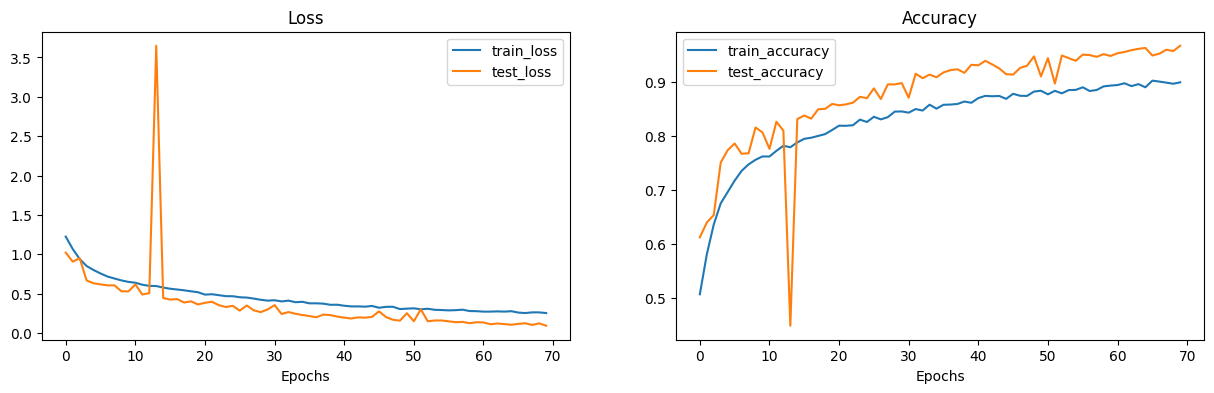

In [30]:
plot_loss_curves(model_results)

## 10. Saving Model

In [31]:
from pathlib import Path

MODEL_PATH = Path("/content/drive/MyDrive/HK4_N2/DeepLearning/FinalProject_EyesDetection")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "MultipleEyeDiseaseDetectModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: /content/drive/MyDrive/HK4_N2/DeepLearning/FinalProject_EyesDetection/MultipleEyeDiseaseDetectModel.pth


## 11. Loading Model

In [32]:
loaded_model = ImprovedTinyVGGModel(3, 48, 6).to('cpu')
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
ImprovedTinyVGGModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(192, 

## 12. Making Predictions on Loaded Model

In [33]:
def make_predictions(model, data, device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim = 0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [34]:
import random
# random.seed(42)

test_samples = []
test_labels = []
# test_targets_tensor = torch.tensor(test_data.targets)
for sample, label in random.sample(list(test_data), k = 20):
  test_samples.append(sample)
  test_labels.append(label)

In [35]:
test_samples[0].shape

torch.Size([3, 224, 224])

In [36]:
loaded_pred_probs = make_predictions(loaded_model,
                                     test_samples,
                                     device)


loaded_pred_classes = loaded_pred_probs.argmax(dim = 1)

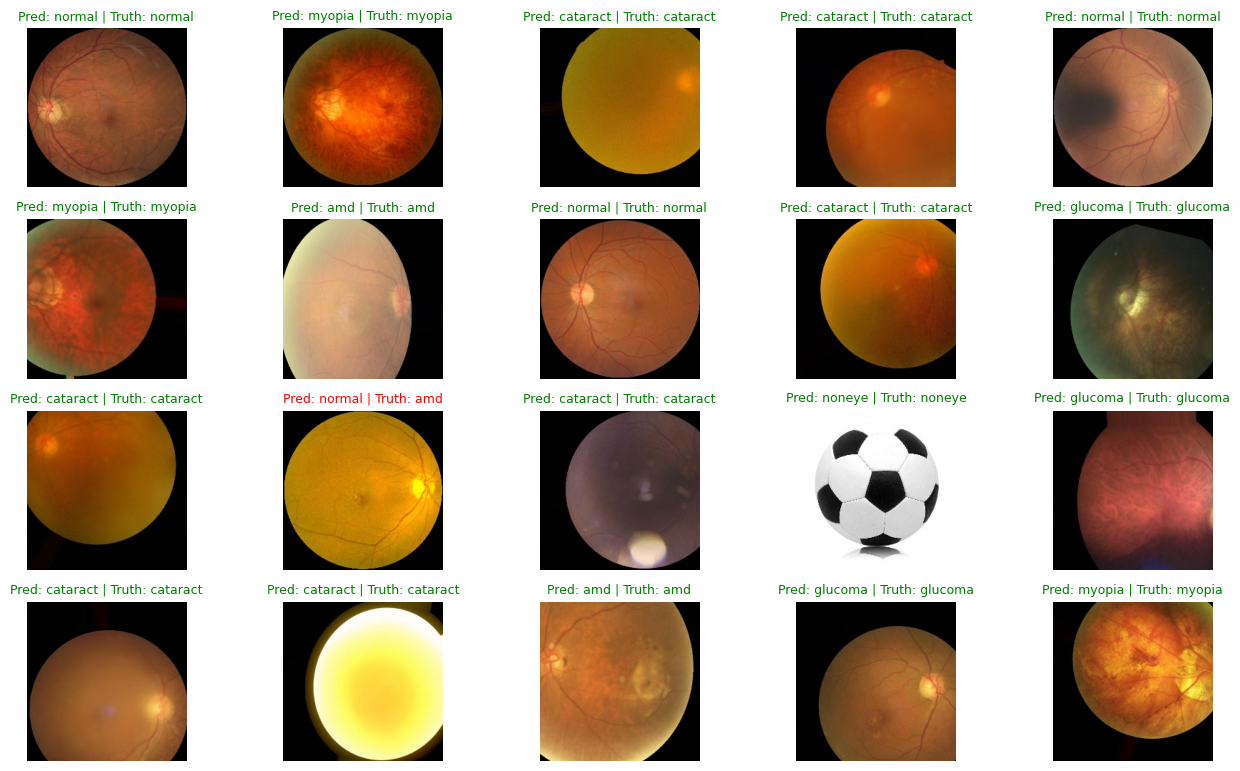

In [37]:
plt.figure(figsize=(16, 12))
nrows, ncols = 5, 5

for i, sample in enumerate(test_samples):
  class_name = np.array(['amd', 'cataract', 'glucoma', 'myopia', 'noneye', 'normal'])
  plt.subplot(nrows, ncols, i + 1)
  normalized_sample = sample.permute(1, 2, 0).numpy()
  # normalized_sample = normalized_sample / 255.0
  plt.imshow(normalized_sample)

  pred_label = class_name[loaded_pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=9, c="g")
  else:
      plt.title(title_text, fontsize=9, c="r")

  plt.axis(False);

## 13. Model Evaluation Metrics (Accuracy, Precision, Recall, F1 Score)

In [38]:
def calculate_test_accuracy(model, test_dataloader, device):
    """Calculate the accuracy of a model on the entire test dataset"""
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Get predictions
            _, predicted = torch.max(y_pred.data, 1)

            # Update counts
            total += y.size(0)
            correct += (predicted == y).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy on entire dataset: {accuracy:.4f} ({correct}/{total})")
    return accuracy

# Calculate the full test accuracy
test_accuracy = calculate_test_accuracy(loaded_model, test_dataloader, device)

Test Accuracy on entire dataset: 0.9667 (1160/1200)


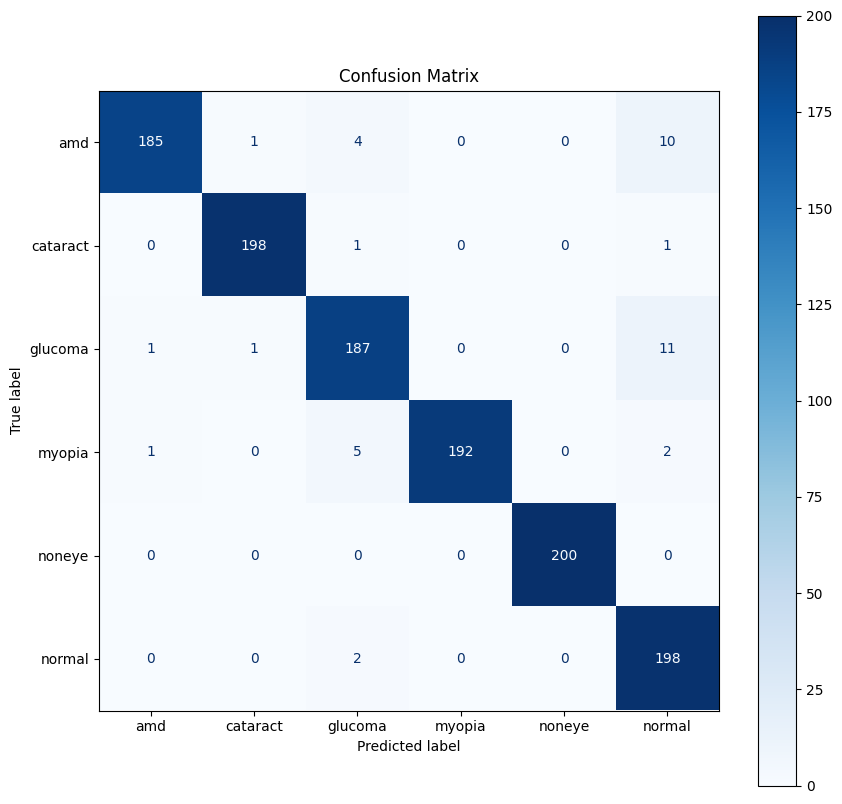

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

def calculate_confusion_matrix(model, test_dataloader, device, class_names):
    """Generate confusion matrix for model evaluation"""
    model.to(device)
    model.eval()
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            outputs = model(X)
            _, preds = torch.max(outputs, 1)

            # Collect all predictions and targets
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    # Create and plot confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

    return all_targets, all_preds, cm

# Calculate confusion matrix
true_labels, predicted_labels, conf_matrix = calculate_confusion_matrix(loaded_model, test_dataloader, device, class_names)


Detailed Classification Metrics:

              precision    recall  f1-score   support

         amd       0.99      0.93      0.96       200
    cataract       0.99      0.99      0.99       200
     glucoma       0.94      0.94      0.94       200
      myopia       1.00      0.96      0.98       200
      noneye       1.00      1.00      1.00       200
      normal       0.89      0.99      0.94       200

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200



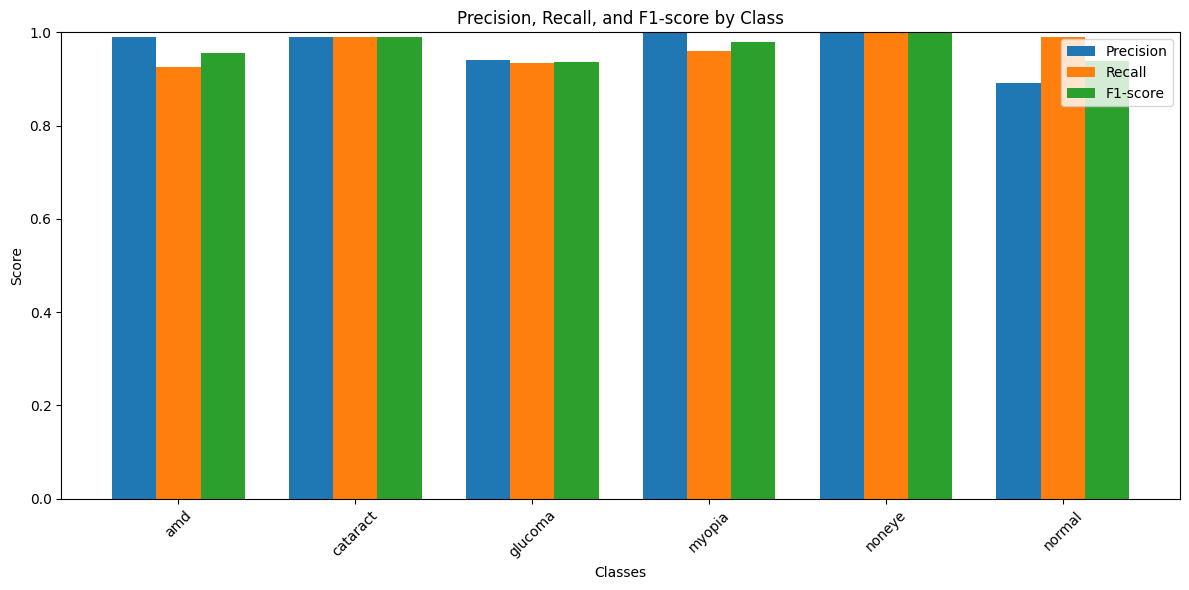

In [40]:
def calculate_metrics(true_labels, predicted_labels, class_names):
    """Calculate precision, recall, and F1 score"""
    # Get the classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)

    # Convert to dataframe for better visualization
    df_report = pd.DataFrame(report).transpose()

    # Display the results
    print("\nDetailed Classification Metrics:")
    print("==================================\n")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Create a bar plot for precision, recall, and f1-score for each class
    plt.figure(figsize=(12, 6))

    # Filter out the 'accuracy', 'macro avg', and 'weighted avg' rows
    df_plot = df_report.iloc[:-3].copy()

    # Plot the metrics
    x = np.arange(len(df_plot.index))
    width = 0.25

    plt.bar(x - width, df_plot['precision'], width, label='Precision')
    plt.bar(x, df_plot['recall'], width, label='Recall')
    plt.bar(x + width, df_plot['f1-score'], width, label='F1-score')

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-score by Class')
    plt.xticks(x, df_plot.index, rotation=45)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_report

# Calculate and visualize metrics
metrics_df = calculate_metrics(true_labels, predicted_labels, class_names)

In [41]:
def analyze_per_class_metrics(conf_matrix, class_names):
    """Calculate per-class precision, recall, and F1-score from confusion matrix"""
    # Number of classes
    n_classes = len(class_names)

    # Initialize arrays to store metrics
    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f1_score = np.zeros(n_classes)

    # Calculate metrics for each class
    for i in range(n_classes):
        # True positives: diagonal elements of confusion matrix
        tp = conf_matrix[i, i]

        # False positives: sum of column i excluding the diagonal element
        fp = np.sum(conf_matrix[:, i]) - tp

        # False negatives: sum of row i excluding the diagonal element
        fn = np.sum(conf_matrix[i, :]) - tp

        # Calculate precision: TP / (TP + FP)
        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0

        # Calculate recall: TP / (TP + FN)
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Calculate F1 score: 2 * (precision * recall) / (precision + recall)
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    # Create a summary table
    summary = {
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }

    summary_df = pd.DataFrame(summary)

    # Add row for average metrics
    summary_df.loc[n_classes] = ['Average',
                               np.mean(precision),
                               np.mean(recall),
                               np.mean(f1_score)]

    print("\nPer-Class Performance Metrics (Manual Calculation):")
    print("=================================================")
    print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    return summary_df

# Calculate and display per-class metrics
per_class_metrics = analyze_per_class_metrics(conf_matrix, class_names)


Per-Class Performance Metrics (Manual Calculation):
   Class  Precision  Recall  F1-Score
     amd     0.9893  0.9250    0.9561
cataract     0.9900  0.9900    0.9900
 glucoma     0.9397  0.9350    0.9373
  myopia     1.0000  0.9600    0.9796
  noneye     1.0000  1.0000    1.0000
  normal     0.8919  0.9900    0.9384
 Average     0.9685  0.9667    0.9669


## 14. Overall Model Performance Summary

The model's performance has been evaluated using multiple metrics:

1. **Accuracy**: The proportion of correct predictions among the total number of test samples
2. **Precision**: The ability of the model not to label as positive a sample that is negative (TP / (TP + FP))
3. **Recall**: The ability of the model to find all positive samples (TP / (TP + FN))
4. **F1-Score**: The harmonic mean of precision and recall, useful when class distribution is imbalanced

These metrics help us understand how well the model performs overall and for each class separately.

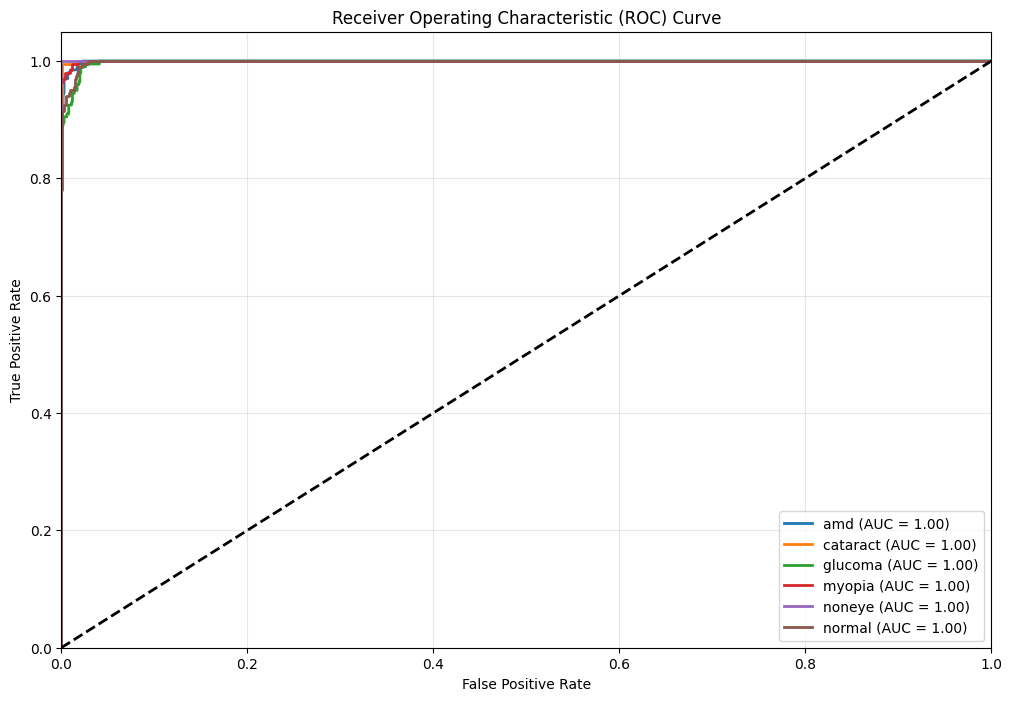

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curves(model, test_dataloader, class_names, device):
    """Plot ROC curves and calculate AUC for each class"""
    model.to(device)
    model.eval()
    all_probs = []
    all_targets = []

    n_classes = len(class_names)

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            outputs = model(X)
            probabilities = torch.softmax(outputs, dim=1)

            # Collect all probabilities and targets
            all_probs.extend(probabilities.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)

    # Binarize labels for ROC curve calculation
    all_targets_bin = label_binarize(all_targets, classes=range(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(all_targets_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(12, 8))

    # Plot individual class ROC curves
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    # Plot the random guess line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    return roc_auc

# Plot ROC curves and calculate AUC
roc_auc_scores = plot_roc_curves(loaded_model, test_dataloader, class_names, device)